# Decoding Cross Subjects

## Import the modules

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_validate
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from collections import Counter
%matplotlib inline

### Define the score function for estimate the Roc Auc score

In [2]:
def score_func(y, y_pred):
    score = roc_auc_score(y, y_pred, multi_class="ovo")
    return score

In [3]:
my_scores = make_scorer(score_func=score_func, greater_is_better=True, needs_proba=True, needs_threshold=False)

## Set the path and load the dataset

In [4]:
os.getcwd()

'/Users/zhengyuanrui/FastSame-Sequence/2_Analysis/2_Result'

In [5]:
os.chdir("../../1_Data/2_Postpro_data")

In [6]:
df = pd.read_csv("Exp2_RT.csv")

In [7]:
df.head()

,subj_idx,gender,year,education,dist,trial_type,rt,response,key_press,condition,correct_response,correct,word,Image,shape_en,valence,ACC,exp,matchness,trial_id
0,1,0,2000,5,408.81,psychophysics,822,f,f,image_first,f,True,常人,img/S_ambi40.png,square,Neutral,1,exp2,mismatch,1
1,1,0,2000,5,408.81,psychophysics,741,f,f,image_first,f,True,好人,img/T_ambi40.png,triangle,Good,1,exp2,mismatch,2
2,1,0,2000,5,408.81,psychophysics,781,j,j,image_first,j,True,常人,img/T_ambi40.png,triangle,Neutral,1,exp2,match,3
3,1,0,2000,5,408.81,psychophysics,683,f,f,image_first,f,True,坏人,img/C_ambi40.png,circle,Bad,1,exp2,mismatch,4
4,1,0,2000,5,408.81,psychophysics,599,j,j,image_first,j,True,常人,img/T_ambi40.png,triangle,Neutral,1,exp2,match,5


## Select the columns and split the dataset by condition

In [8]:
column = ['subj_idx', 'gender', 'year','education', 'condition', 'valence', 'matchness', 'rt', 'ACC']

In [9]:
df = df[column]

In [10]:
df.head()

,subj_idx,gender,year,education,condition,valence,matchness,rt,ACC
0,1,0,2000,5,image_first,Neutral,mismatch,822,1
1,1,0,2000,5,image_first,Good,mismatch,741,1
2,1,0,2000,5,image_first,Neutral,match,781,1
3,1,0,2000,5,image_first,Bad,mismatch,683,1
4,1,0,2000,5,image_first,Neutral,match,599,1


In [11]:
df["valence"] = df["valence"].map(dict(Neutral=0, Bad=1, Good=2))
df["matchness"] = df["matchness"].map(dict(mismatch=0, match=1))

Check the basic information of df

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16943 entries, 0 to 16942
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subj_idx   16943 non-null  int64 
 1   gender     16943 non-null  int64 
 2   year       16943 non-null  int64 
 3   education  16943 non-null  int64 
 4   condition  16943 non-null  object
 5   valence    16943 non-null  int64 
 6   matchness  16943 non-null  int64 
 7   rt         16943 non-null  int64 
 8   ACC        16943 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 1.2+ MB


### Check the distribution of the reaction time

(array([ 172., 2523., 5297., 4351., 2325., 1166.,  552.,  322.,  154.,
          81.]),
 array([ 307. ,  425.8,  544.6,  663.4,  782.2,  901. , 1019.8, 1138.6,
        1257.4, 1376.2, 1495. ]),
 <BarContainer object of 10 artists>)

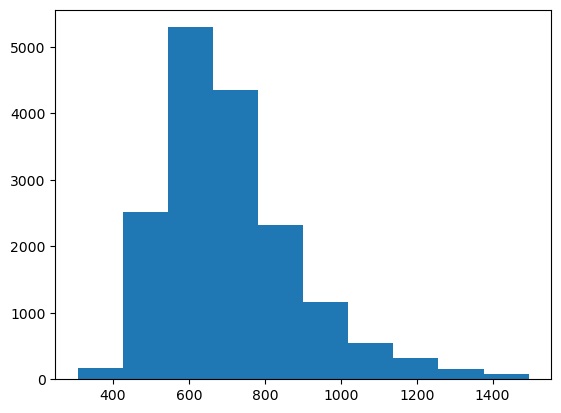

In [13]:
plt.hist(df['rt'])

log transform on the reaction time

In [14]:
df['rt_log'] = np.log(df['rt'])

(array([  14.,  142.,  943., 2993., 4525., 4032., 2382., 1164.,  542.,
         206.]),
 array([5.72684775, 5.88515112, 6.0434545 , 6.20175787, 6.36006124,
        6.51836462, 6.67666799, 6.83497136, 6.99327474, 7.15157811,
        7.30988149]),
 <BarContainer object of 10 artists>)

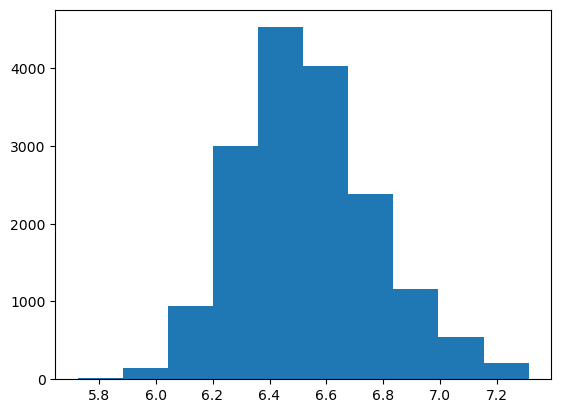

In [15]:
plt.hist(df['rt_log'])

In [16]:
df.condition.unique()

array(['image_first', 'word_first', 'simultaneous'], dtype=object)

In [17]:
df_sim = df.query("condition == 'simultaneous'")

In [18]:
df_img = df.query("condition == 'image_first'")

In [19]:
df_word = df.query("condition == 'word_first'")

In [20]:
Counter(df_sim["ACC"])

Counter({1: 5604})

In [21]:
Counter(df_word["ACC"])

Counter({1: 5662})

In [22]:
Counter(df_img["ACC"])

Counter({1: 5677})

# valence as the dependent variable

## Make pipeline 

In [23]:
pipe_lr = make_pipeline(
    MinMaxScaler(), 
    LogisticRegression(solver='saga', multi_class="multinomial", max_iter=1000, random_state=123)
)

In [24]:
pipe_rf = make_pipeline(
    MinMaxScaler(), 
   RandomForestClassifier(n_estimators=10, bootstrap=False, random_state=123, class_weight="balanced", max_samples=None, n_jobs=-1)
)

In [25]:
logo = LeaveOneGroupOut()

## Analysis for the condition of simultaneous

In [26]:
y_sim = df_sim["valence"].values

In [27]:
Counter(y_sim)

Counter({1: 1823, 0: 1886, 2: 1895})

In [28]:
X_sim = df_sim[['rt_log']].values

In [29]:
X_sim.shape

(5604, 1)

In [30]:
y_sim.shape

(5604,)

In [31]:
sim_groups = df_sim["subj_idx"].values

In [32]:
np.unique(sim_groups)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [33]:
sim_scores_lr = cross_validate(pipe_lr, X_sim, y_sim, groups=sim_groups, cv=logo, scoring=my_scores, return_train_score=True)

In [34]:
sim_scores_lr['test_score'].mean()

0.5234921916409829

In [35]:
sim_scores_rf = cross_validate(pipe_rf, X_sim, y_sim, groups=sim_groups, cv=logo, scoring=my_scores)

In [36]:
sim_scores_rf['test_score'].mean()

0.5003517316620013

In [37]:
score_sim_lr, perm_scores_sim_lr, pvalue_sim_lr = permutation_test_score(pipe_lr, X_sim, y_sim, cv=logo, groups=sim_groups, n_permutations=100, n_jobs=-1, random_state=123, verbose=1, scoring=my_scores, fit_params=None)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.3s finished


In [38]:
score_sim_rf, perm_scores_sim_rf, pvalue_sim_rf = permutation_test_score(pipe_rf, X_sim, y_sim, cv=logo, groups=sim_groups, n_permutations=100, n_jobs=-1, random_state=123, verbose=1, scoring=my_scores, fit_params=None)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


In [39]:
score_sim_lr

0.5234921916409829

In [40]:
score_sim_rf

0.5003517316620013

In [41]:
pvalue_sim_lr

0.009900990099009901

In [42]:
pvalue_sim_rf

0.36633663366336633

#### permutation importance

In [56]:
from sklearn.inspection import permutation_importance

In [57]:
pi = list()

In [62]:
for train_ix, test_ix in logo.split(X = X_sim, groups=sim_groups):
    X_train, X_test = X_sim[train_ix, :], X_sim[test_ix, :]
    y_train, y_test = y_sim[train_ix], y_sim[test_ix]
    clf = pipe_lr.fit(X_train, y_train)
    result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=0)
    pi.append(result)

In [63]:
pi

[{'importances_mean': array([0.03443969]),
  'importances_std': array([0.00604554]),
  'importances': array([[0.04050678, 0.03015703, 0.03658101, 0.03729479, 0.02890792,
          0.02159172, 0.04443255, 0.0340828 , 0.03551035, 0.03533191]])},
 {'importances_mean': array([0.03827623]),
  'importances_std': array([0.00661219]),
  'importances': array([[0.04264811, 0.0324768 , 0.041399  , 0.04122056, 0.02980014,
          0.02498216, 0.04800143, 0.04229122, 0.03925767, 0.04068522]])},
 {'importances_mean': array([0.03147752]),
  'importances_std': array([0.00612414]),
  'importances': array([[0.03818701, 0.02926481, 0.0296217 , 0.03426124, 0.0251606 ,
          0.01927195, 0.04229122, 0.03087081, 0.03158458, 0.03426124]])},
 {'importances_mean': array([0.03659886]),
  'importances_std': array([0.00646029]),
  'importances': array([[0.04157744, 0.03069236, 0.039793  , 0.03997145, 0.02855103,
          0.02337616, 0.04550321, 0.03943612, 0.03765168, 0.03943612]])},
 {'importances_mean': ar

## Analysis for the condition of word_first

In [295]:
y_word = df_word["valence"].values

In [296]:
X_word = df_word[['rt_log']].values

In [297]:
y_word.shape

(4386,)

In [298]:
X_word.shape

(4386, 1)

In [299]:
word_groups = df_word['subj_idx'].values

In [300]:
np.unique(word_groups)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [301]:
word_scores_lr = cross_validate(pipe_lr, X_word, y_word, groups=word_groups, cv=logo, scoring=my_scores)

In [302]:
word_scores_lr['test_score'].mean()

0.5424537357662305

In [303]:
word_scores_rf = cross_validate(pipe_rf, X_word, y_word, groups=word_groups, cv=logo, scoring=my_scores)

In [304]:
word_scores_rf['test_score'].mean()

0.5032947358929231

In [305]:
score_word_lr, perm_scores_word_lr, pvalue_word_lr = permutation_test_score(pipe_lr, X_word, y_word, cv=logo, groups=word_groups, n_permutations=100, n_jobs=-1, random_state=123, verbose=1, scoring=my_scores, fit_params=None)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.5s finished


In [306]:
score_word_rf, perm_scores_word_rf, pvalue_word_rf = permutation_test_score(pipe_rf, X_word, y_word, cv=logo, groups=word_groups, n_permutations=100, n_jobs=-1, random_state=123, verbose=1, scoring=my_scores, fit_params=None)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   47.0s finished


In [307]:
score_word_lr

0.5424537357662305

In [308]:
score_word_rf

0.5032947358929231

In [309]:
pvalue_word_lr

0.009900990099009901

In [310]:
pvalue_word_rf

0.36633663366336633

## Analysis for the condition of image_first

In [311]:
y_img = df_img['valence'].values

In [312]:
X_img = df_img[['rt_log']]

In [313]:
y_img.shape

(4411,)

In [314]:
X_img.shape

(4411, 1)

In [315]:
img_groups = df_img['subj_idx'].values

In [316]:
np.unique(img_groups)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [317]:
img_scores_lr = cross_validate(pipe_lr, X_img, y_img, groups=img_groups, cv=logo, scoring=my_scores)

In [318]:
img_scores_lr['test_score'].mean()

0.5369782640836566

In [319]:
img_scores_rf = cross_validate(pipe_rf, X_img, y_img, groups=img_groups, cv=logo, scoring=my_scores)

In [320]:
img_scores_rf['test_score'].mean()

0.5149671178638091

In [321]:
score_img_lr, perm_scores_img_lr, pvalue_img_lr = permutation_test_score(pipe_lr, X_img, y_img, cv=logo, groups=img_groups, n_permutations=100, n_jobs=-1, random_state=123, verbose=1, scoring=my_scores, fit_params=None)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.7s finished


In [322]:
score_img_rf, perm_scores_img_rf, pvalue_img_rf = permutation_test_score(pipe_rf, X_img, y_img, cv=logo, groups=img_groups, n_permutations=100, n_jobs=-1, random_state=123, verbose=1, scoring=my_scores, fit_params=None)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.9s finished


In [323]:
score_img_lr

0.5369782640836566

In [324]:
score_img_rf

0.5149671178638091

In [325]:
pvalue_img_lr

0.009900990099009901

In [326]:
pvalue_img_rf

0.10891089108910891

# matchness as the dependent variable

## Make pipeline

In [327]:
pipe_lr_m = make_pipeline(
    MinMaxScaler(), 
    LogisticRegression(solver="saga", max_iter=1000, random_state=123)
)

In [328]:
pipe_rf_m = make_pipeline(
    MinMaxScaler(), 
    RandomForestClassifier(n_estimators=10, bootstrap=False, random_state=123, class_weight="balanced", max_samples=None)
)

## Analysis for the condition of simultaneous

In [329]:
y_sim_m = df_sim['matchness'].values

In [330]:
y_sim_m.shape

(4304,)

In [331]:
X_sim.shape

(4304, 1)

In [332]:
sim_scores_lr_m = cross_validate(pipe_lr_m, X_sim, y_sim_m, groups=sim_groups, cv=logo, scoring=my_scores)

In [333]:
sim_scores_lr_m['test_score'].mean()

0.6449849659251353

In [334]:
sim_scores_rf_m = cross_validate(pipe_rf_m, X_sim, y_sim_m, groups=sim_groups, cv=logo, scoring=my_scores)

In [335]:
sim_scores_rf_m['test_score'].mean()

0.5681660551444014

In [336]:
score_sim_lr_m, perm_scores_sim_lr_m, pvalue_sim_lr_m = permutation_test_score(pipe_lr_m, X_sim, y_sim_m, cv=logo, groups=sim_groups, n_permutations=100, n_jobs=-1, random_state=123, verbose=1, scoring=my_scores, fit_params=None)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.4s finished


In [337]:
score_sim_rf_m, perm_scores_sim_rf_m, pvalue_sim_rf_m = permutation_test_score(pipe_rf_m, X_sim, y_sim_m, cv=logo, groups=sim_groups, n_permutations=100, n_jobs=-1, random_state=123, verbose=1, scoring=my_scores, fit_params=None)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.4s finished


In [338]:
score_sim_lr_m

0.6449849659251353

In [339]:
score_sim_rf_m

0.5681660551444014

In [340]:
pvalue_sim_lr_m

0.009900990099009901

In [341]:
pvalue_sim_rf_m

0.009900990099009901

## Analysis for condition of word_first

In [342]:
y_word_m = df_word['matchness'].values

In [343]:
word_scores_lr_m = cross_validate(pipe_lr_m, X_word, y_word_m, groups=word_groups, cv=logo, scoring=my_scores)

In [344]:
word_scores_lr_m['test_score'].mean()

0.6331053954596224

In [345]:
word_scores_rf_m = cross_validate(pipe_rf_m, X_word, y_word_m, groups=word_groups, cv=logo, scoring=my_scores)

In [346]:
word_scores_rf_m['test_score'].mean()

0.5616882997235634

In [347]:
score_word_lr_m, perm_scores_word_lr_m, pvalue_word_lr_m = permutation_test_score(pipe_lr_m, X_word, y_word_m, cv=logo, groups=word_groups, n_permutations=100, n_jobs=-1, random_state=123, verbose=1, scoring=my_scores, fit_params=None)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.3s finished


In [348]:
score_word_rf_m, perm_scores_word_rf_m, pvalue_word_rf_m = permutation_test_score(pipe_rf_m, X_word, y_word_m, cv=logo, groups=word_groups, n_permutations=100, n_jobs=-1, random_state=123, verbose=1, scoring=my_scores, fit_params=None)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   53.5s finished


In [349]:
score_word_lr_m

0.6331053954596224

In [350]:
score_word_rf_m

0.5616882997235634

In [351]:
pvalue_word_lr_m

0.009900990099009901

In [352]:
pvalue_word_rf_m

0.009900990099009901

## Analysis for condition of image_first

In [353]:
y_img_m = df_img['matchness'].values

In [354]:
img_scores_lr_m = cross_validate(pipe_lr_m, X_img, y_img_m, groups=img_groups, cv=logo, scoring=my_scores)

In [355]:
img_scores_lr_m['test_score'].mean()

0.6108109378647286

In [356]:
img_scores_rf_m = cross_validate(pipe_rf_m, X_img, y_img_m, groups=img_groups, cv=logo, scoring=my_scores)

In [357]:
img_scores_rf_m['test_score'].mean()

0.5533277763041702

In [358]:
score_img_lr_m, perm_scores_img_lr_m, pvalue_img_lr_m = permutation_test_score(pipe_lr_m, X_img, y_img_m, cv=logo, groups=img_groups, n_permutations=100, n_jobs=-1, random_state=123, verbose=1, scoring=my_scores, fit_params=None)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.9s finished


In [359]:
score_img_rf_m, perm_scores_img_rf_m, pvalue_img_rf_m = permutation_test_score(pipe_rf_m, X_img, y_img_m, cv=logo, groups=img_groups, n_permutations=100, n_jobs=-1, random_state=123, verbose=1, scoring=my_scores, fit_params=None)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.4s finished


In [360]:
pvalue_img_rf_m

0.009900990099009901

In [361]:
score_img_rf_m

0.5533277763041702

In [362]:
score_img_lr_m

0.6108109378647286

In [363]:
pvalue_img_lr_m

0.009900990099009901